(<Figure size 7400x800 with 1 Axes>, <Axes: >)


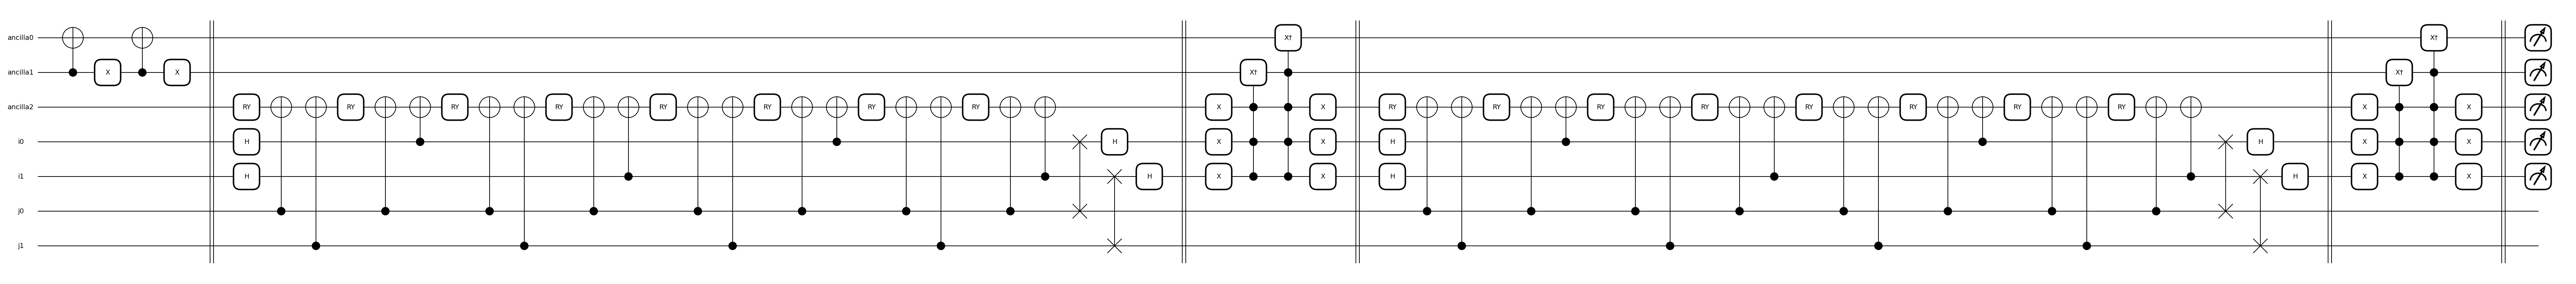

In [113]:
import pennylane as qml
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code
import numpy as np
import itertools
from scipy.sparse import diags

tolerance = 0.001

def matrix(n):
    temp = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]
    offset = [-1, 0, 1]
    K = diags(temp, offset).toarray()
    K[0, 2:n] = 0
    K[n-1, 1:n] = 0
    K[0, 1] = 1
    K[0, 0] = -2
    K[n-1, n-2] = 1
    K[n-1, n-1] = -2
    K[0, n-1] = 0
    K[n-1, 0] = 0
    return K

nqbit1 = 2
A = matrix(2**nqbit1)
A = (A + 2*np.identity(2**nqbit1))
A = np.array(A)

alphas_1 = np.arccos(A).flatten()
thetas_1 = compute_theta(alphas_1)

ancilla_wires = ["ancilla0", "ancilla1", "ancilla2"]

s = int(np.log2(A.shape[0]))
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]

code = gray_code(2 * np.log2(len(A)))
n_selections = len(code)

control_wires = [int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % n_selections], 2))) for i in range(n_selections)]

wire_map = {control_index: wire for control_index, wire in enumerate(wires_j + wires_i)}

def ADD(ancilla_wires):
    ancilla = ancilla_wires[:2]
    controls = list(range(len(ancilla) - 2, -1, -1))
    for p in range(len(ancilla) - 1):
        qml.MultiControlledX(wires=[ancilla[-1], *ancilla[:len(controls)]], control_values='1' * len(controls))
        controls.pop()
    qml.PauliX(wires=ancilla[-1])
    
def DAGGER_ADD(ancilla_wires):
    qml.adjoint(ADD)(ancilla_wires)

def SUB(ancilla_wires):
    ancilla = ancilla_wires[:2]
    controls = list(range(len(ancilla) - 2, -1, -1))
    for p in range(len(ancilla) - 1):
        qml.MultiControlledX(wires=[ancilla[-1], *ancilla[:len(controls)]], control_values='0' * len(controls))
        controls.pop()
    qml.PauliX(wires=ancilla[-1])
    
def apply_operations_sub(ancilla_wires):
    SUB(ancilla_wires)

def ctrl_DAGGER_ADD(ancilla_wires, wires_i):
    control_qubits = [ancilla_wires[-1]] + wires_i  # Combine the control qubit and wires_i into a list
    k = len(control_qubits)
    
    control_values = list(itertools.product([0, 1], repeat=k))
    
    qml.ctrl(DAGGER_ADD, control=control_qubits, control_values=control_values[0])(ancilla_wires)

def apply_operations_add(ancilla_wires):
    ADD(ancilla_wires)
    ADD(ancilla_wires)

def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        qml.RY(2 * theta, wires=ancilla[-1])
        qml.CNOT(wires=[wire_map[control_index], ancilla[-1]])

def UA_decompose(thetas, control_wires, ancilla):
    nots = []
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            for c_wire in nots:
                qml.CNOT(wires=[c_wire, ancilla[-1]])
            qml.RY(2 * theta, wires=ancilla[-1])
            nots = []
        if (cw := wire_map[control_index]) in nots:
            del nots[nots.index(cw)]
        else:
            nots.append(wire_map[control_index])
    for c_wire in nots:
        qml.CNOT(wires=[c_wire, ancilla[-1]])

def UB(wires_i, wires_j):
    for w_i, w_j in zip(wires_i, wires_j):
        qml.SWAP(wires=[w_i, w_j])

def HN(input_wires):
    for w in input_wires:
        qml.Hadamard(wires=w)

dev = qml.device('default.qubit', wires=ancilla_wires + wires_i + wires_j)

def circuit(thetas):
    HN(wires_i)
    UA_decompose(thetas, control_wires, ancilla_wires)
    UB(wires_i, wires_j)
    HN(wires_i)

@qml.qnode(dev)
def complete_circuit(ancilla, wires_i, thetas):
    ADD(ancilla)
    ADD(ancilla)
    qml.Barrier()
    
    circuit(thetas)
    qml.Barrier()
    
    ctrl_DAGGER_ADD(ancilla, wires_i)
    qml.Barrier()
    
    circuit(thetas)
    qml.Barrier()
    
    ctrl_DAGGER_ADD(ancilla, wires_i)
    qml.Barrier()
    
    return qml.probs(wires=ancilla_wires + wires_i)

print(qml.draw_mpl(complete_circuit)(ancilla_wires, wires_i, thetas_1))


In [115]:
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = 2**nqbit1*len(A) * qml.matrix(complete_circuit,wire_order=wire_order)(ancilla_wires,wires_i, thetas_1).real[0:len(A),0:len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")




Block-encoded matrix:
[[1.00000000e+00 4.84232010e-16 1.00000000e+00 1.65875675e-16]
 [2.06729459e-16 2.00000000e+00 5.70708696e-16 1.00000000e+00]
 [1.00000000e+00 5.70708696e-16 2.00000000e+00 2.06729459e-16]
 [1.65875675e-16 1.00000000e+00 4.84232010e-16 1.00000000e+00]] 



/home_local/local/.local/lib/python3.10/site-packages/pennylane/ops/op_math/controlled_ops.py:1045: PennyLaneDeprecationWarning: Specifying control values using a bitstring is deprecated, and will not be supported in future releases, Use a list of booleans or integers instead.
  warnings.warn(


In [116]:
print(f"matrix:{A@A}", "\n")

matrix:[[1. 0. 1. 0.]
 [0. 2. 0. 1.]
 [1. 0. 2. 0.]
 [0. 1. 0. 1.]] 

